In [7]:
import random
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, transpile
from VQLS import specialHadamardTest, getBArray, getMatrixCoeffitients, getApproximationValue, plotCost, ansatzTest, hadamardTest
from Utils import createMatrixFromParameters 
from qiskit import Aer
from qiskit.quantum_info import PauliList, SparsePauliOp
import matplotlib.pyplot as plt
import time


In [8]:
costHistory = []
def calculateCostFunctionMatrix(parameters: list, args: list) -> float:
    overallSum1 = 0
    overallSum2 = 0
    backend = Aer.get_backend("aer_simulator")

    coefficientSet = args[0]
    transpiledHadamardCircuits = args[1]
    parametersHadamard = args[2]
    transpiledSpecialHadamardCircuits = args[3]
    parametersSpecialHadamard = args[4]

    qcrs = [i.bind_parameters({parametersHadamard: parameters}) for i in transpiledHadamardCircuits]
    qcrs1 = [i.bind_parameters({parametersSpecialHadamard: parameters}) for i in transpiledSpecialHadamardCircuits]
    lenPaulis = len(qcrs1)

    for i in range(lenPaulis):
        for j in range(lenPaulis):
            job = backend.run(qcrs[i*lenPaulis + j])
            result = job.result()
            outputstate = np.real(result.get_statevector(qcrs[i*lenPaulis + j], decimals=100))

            m_sum = 0
            for l in range(len(outputstate)):
                if l % 2 == 1:
                    n = outputstate[l] ** 2
                    m_sum += n

            multiply = coefficientSet[i] * coefficientSet[j]
            overallSum1 += multiply * (1 - (2 * m_sum))

    resultVectors = []
    for i in range(lenPaulis):
        job = backend.run(qcrs1[i])
        result = job.result()
        outputstate = np.real(result.get_statevector(qcrs1[i], decimals=100))
        resultVectors.append(outputstate)

    for i in range(lenPaulis):  # optimize it little bit more
        for j in range(lenPaulis):
            mult = 1
            for extra in range(2):
                if extra == 0:
                    outputstate = resultVectors[i]
                if extra == 1:
                    outputstate = resultVectors[j]

                m_sum = 0
                for l in range(len(outputstate)):
                    if l % 2 == 1:
                        n = outputstate[l] ** 2
                        m_sum += n
                mult = mult * (1 - (2 * m_sum))

            multiply = coefficientSet[i] * coefficientSet[j]
            overallSum2 += multiply * mult

    totalCost = 1 - float(overallSum2.real / overallSum1.real)
    # print(totalCost)
    costHistory.append(totalCost)
    return totalCost

In [9]:
def calculateCostFunctionQuantumSimulation(
    parameters: list, args: list
) -> float:
    overallSum1 = 0
    overallSum2 = 0
    backend = Aer.get_backend("aer_simulator")

    coefficientSet = args[0]
    transpiledHadamardCircuits = args[1]
    parametersHadamard = args[2]
    transpiledSpecialHadamardCircuits = args[3]
    parametersSpecialHadamard = args[4]
    shots = args[5]

    qcrs = [i.bind_parameters({parametersHadamard: parameters}) for i in transpiledHadamardCircuits]
    qcrs1 = [i.bind_parameters({parametersSpecialHadamard: parameters}) for i in transpiledSpecialHadamardCircuits]
    lenPaulis = len(qcrs1)

    for i in range(lenPaulis):
        for j in range(lenPaulis):
            job = backend.run(qcrs[i*lenPaulis + j], shots=shots)
            result = job.result()
            outputstate = result.get_counts(qcrs[i*lenPaulis + j])

            if "1" in outputstate.keys():
                m_sum = float(outputstate["1"]) / shots
            else:
                m_sum = 0

            multiply = coefficientSet[i] * coefficientSet[j]
            overallSum1 += multiply * (1 - 2 * m_sum)

    resultVectors = []
    for i in range(lenPaulis):
        job = backend.run(qcrs1[i], shots=shots)
        result = job.result()
        outputstate = result.get_counts(qcrs1[i])
        resultVectors.append(outputstate)

    for i in range(lenPaulis):
        for j in range(lenPaulis):
            mult = 1
            for extra in range(2):
                if extra == 0:
                    outputstate = resultVectors[i]
                if extra == 1:
                    outputstate = resultVectors[j]

                if "1" in outputstate.keys():
                    m_sum = float(outputstate["1"]) / shots
                else:
                    m_sum = 0

                mult = mult * (1 - 2 * m_sum)

            multiply = coefficientSet[i] * coefficientSet[j]
            overallSum2 += multiply * mult

    totalCost = 1 - float(overallSum2.real / overallSum1.real)
    costHistory.append(totalCost)
    return totalCost

In [10]:
def minimization(
    paulis: PauliList,
    coefficientSet: list,
    totalNeededQubits: int,
    bVector: list,
    quantumSimulation: bool = False,
    method: str = "COBYLA",
    shots: int = 100000,
) -> list:
    global costHistory
    costHistory = []
    x = [float(random.randint(0, 3000)) for _ in range(0, 9)]
    x = x / np.linalg.norm(x)
    start = time.time()
    (
        transpiledHadamardCircuits,
        parametersHadamard,
        transpiledSpecialHadamardCircuits,
        parametersSpecialHadamard,
    ) = prepareCircuits(
        paulis, bVector, totalNeededQubits, quantumSimulation, "aer_simulator"
    )
    end = time.time()
    print("Time to prepare circuits:", end - start)
    start = time.time()
    if quantumSimulation:
        out = minimize(
            calculateCostFunctionQuantumSimulation,
            x0=x,
            args=[
                coefficientSet,
                transpiledHadamardCircuits,
                parametersHadamard,
                transpiledSpecialHadamardCircuits,
                parametersSpecialHadamard,
                shots,
            ],
            method=method,
            options={"maxiter": 200},
        )
    else:
        out = minimize(
            calculateCostFunctionMatrix,
            x0=x,
            args=[
                coefficientSet,
                transpiledHadamardCircuits,
                parametersHadamard,
                transpiledSpecialHadamardCircuits,
                parametersSpecialHadamard,
            ],
            method=method,
            options={"maxiter": 200},
        )

    end = time.time()
    print("Time to minimize:", end - start)
    print(out)
    return [out["x"][0:3], out["x"][3:6], out["x"][6:9]]


def prepareCircuits(
    paulis: PauliList,
    bVector: list,
    totalNeededQubits: int,
    isQuantumSimulation: bool,
    backendd: str,
) -> (list, ParameterVector, list, ParameterVector):
    backend = Aer.get_backend(backendd)
    parametersHadamard = ParameterVector("parametersHadarmard", 9)
    parametersSpecialHadamard = ParameterVector("parametersSpecialHadamard", 9)
    parametersHadamardSplit = [
        parametersHadamard[0:3],
        parametersHadamard[3:6],
        parametersHadamard[6:9],
    ]
    parametersSpecialHadamardSplit = [
        parametersSpecialHadamard[0:3],
        parametersSpecialHadamard[3:6],
        parametersSpecialHadamard[6:9],
    ]

    hadamardCircuits = []
    specialHadamardCircuits = []

    for i in range(len(paulis)):
        for j in range(len(paulis)):
            if isQuantumSimulation:
                circ = QuantumCircuit(totalNeededQubits, 1)
            else:
                circ = QuantumCircuit(totalNeededQubits)
            hadamardTest(
                circ, [paulis[i], paulis[j]], [1, 2, 3], 0, parametersHadamardSplit
            )
            if isQuantumSimulation:
                circ.measure(0, 0)
            else:
                circ.save_statevector()
            hadamardCircuits.append(circ)

    transpiledHadamardCircuits = transpile(hadamardCircuits, backend=backend)

    for i in range(len(paulis)):
        if isQuantumSimulation:
            circ = QuantumCircuit(totalNeededQubits, 1)
        else:
            circ = QuantumCircuit(totalNeededQubits)
        specialHadamardTest(
            circ, [paulis[i]], [1, 2, 3], 0, parametersSpecialHadamardSplit, bVector
        )
        if isQuantumSimulation:
            circ.measure(0, 0)
        else:
            circ.save_statevector()
        specialHadamardCircuits.append(circ)

    transpiledSpecialHadamardCircuits = transpile(
        specialHadamardCircuits, backend=backend
    )

    return (
        transpiledHadamardCircuits,
        parametersHadamard,
        transpiledSpecialHadamardCircuits,
        parametersSpecialHadamard,
    )

Time to prepare circuits: 0.17914915084838867
Time to minimize: 0.825584888458252
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.03746684579591919
       x: [ 1.659e+00  1.378e+00  1.565e+00  1.600e+00  5.322e-01
            1.518e+00 -1.376e+00 -2.056e-01 -2.120e-01]
    nfev: 200
   maxcv: 0.0
Statevector([-0.0535513 +0.j,  0.59693666+0.j,  0.05118642+0.j,
             -0.30193051+0.j,  0.04962246+0.j, -0.39410339+0.j,
             -0.04909021+0.j,  0.62195425+0.j],
            dims=(2, 2, 2))
[-0.0535513 +0.j  0.05969367+0.j  0.05118642+0.j -0.03019305+0.j
  0.04962246+0.j -0.03941034+0.j -0.04909021+0.j  0.06219543+0.j]
[-0.37626045+0.j  0.41941776+0.j  0.35964441+0.j -0.21214147+0.j
  0.34865575+0.j -0.27690369+0.j -0.34491611+0.j  0.43699555+0.j]
0.01570805080007383


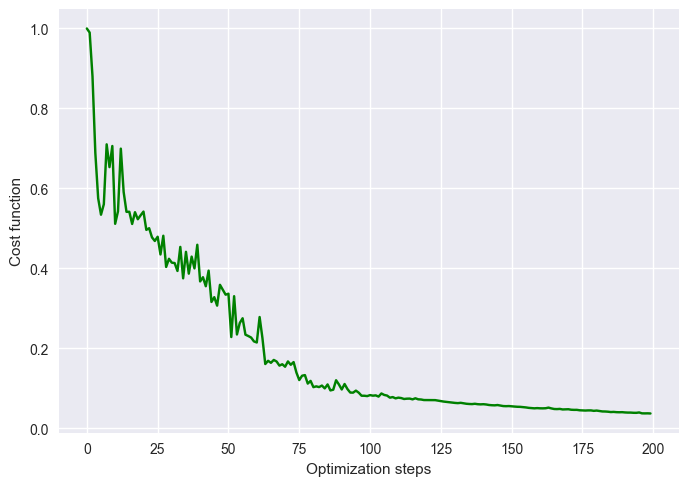

In [11]:
bVector = getBArray([1, 1, 1, 1, 1, 1, 1, 1])
A = createMatrixFromParameters([0.45, 0.55], ["ZII", "III"])

pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
coefficientSet = getMatrixCoeffitients(pauliOp)

outF = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=bVector,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

print(o)
print(A.dot(o))
print((A.dot(o) / (np.linalg.norm(A.dot(o)))))
print(getApproximationValue(A, bVector, o))
plt.style.use("seaborn-v0_8")
plt.plot(costHistory, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Time to prepare circuits: 0.20904326438903809
Time to minimize: 58.633288860321045
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.08214213299662088
       x: [ 1.257e+00  2.193e+00  1.724e+00  1.594e+00 -8.102e-03
            1.465e+00 -6.276e-01 -2.440e-01  2.545e-01]
    nfev: 100
   maxcv: 0.0
Statevector([-0.12186066+0.j,  0.19932511+0.j,  0.27427681+0.j,
             -0.578446  +0.j,  0.14871428+0.j, -0.21029422+0.j,
             -0.24729971+0.j,  0.63882329+0.j],
            dims=(2, 2, 2))
[-0.12186066+0.j  0.10962881+0.j  0.15085224+0.j -0.0578446 +0.j
  0.14871428+0.j -0.11566182+0.j -0.13601484+0.j  0.06388233+0.j]
[-0.36569002+0.j  0.32898361+0.j  0.45269045+0.j -0.17358508+0.j
  0.44627466+0.j -0.347088  +0.j -0.40816509+0.j  0.19170362+0.j]
0.001957006928764097


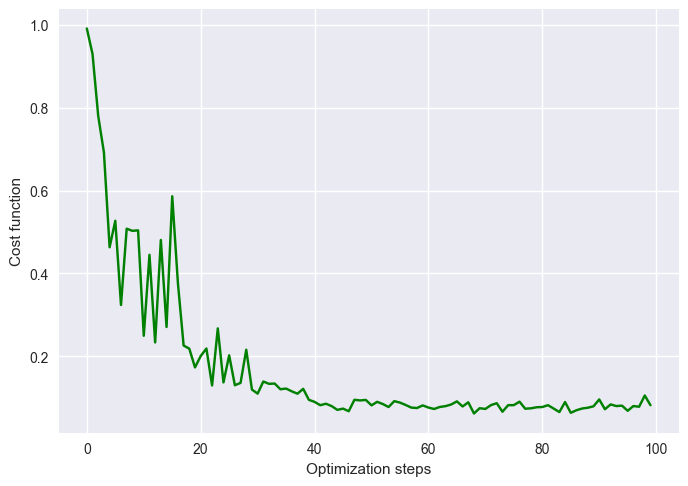

In [12]:
bVector = getBArray([1, 1, 1, 1, 1, 1, 1, 1])
A = createMatrixFromParameters([0.225, 0.225, 0.55], ["ZII", "IZI", "III"])

pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
coefficientSet = getMatrixCoeffitients(pauliOp)

outF = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    quantumSimulation=True,
    bVector=bVector,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

print(o)
print(A.dot(o))
print((A.dot(o) / (np.linalg.norm(A.dot(o)))))
print(getApproximationValue(A, bVector, o))
plt.style.use("seaborn-v0_8")
plt.plot(costHistory, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()